In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import gensim.downloader as api
from gensim.models import Word2Vec

##Data Loading & Exploration

In [2]:
df = pd.read_csv('urban_feedback.csv')
df.head()

,feedback_id,feedback_text,department
0,141,Why does the app need access to my contacts? T...,app_experience
1,114,The station closure information isn't visible ...,service_updates
2,17,The crosswalk at Main and Central is shown in ...,navigation_issues
3,76,The ferry schedule information hasn't been upd...,service_updates
4,156,Every time I try to submit feedback through th...,app_experience


In [4]:
#Examine the dataset to understand its structure
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['department'].value_counts())
print("\nSample feedback per department:")
for dept in df['department'].unique():
    sample_idx = df[df['department'] == dept].index[0]
    print(f"\n{dept.upper()}: {df.loc[sample_idx, 'feedback_text']}")

Dataset shape: (197, 3)

Class distribution:
department
app_experience       66
service_updates      66
navigation_issues    65
Name: count, dtype: int64

Sample feedback per department:

APP_EXPERIENCE: Why does the app need access to my contacts? This seems like a privacy issue.

SERVICE_UPDATES: The station closure information isn't visible until after I've planned a route through it.

NAVIGATION_ISSUES: The crosswalk at Main and Central is shown in the wrong location on your map.


In [5]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [7]:
# Lemmatizer relies of part of speech to help
def get_wordnet_pos(treebank_tag):
  '''
  Translate nltk POS to wordnet tags
  '''
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN

In [8]:
def basic_preprocess(text):
   """Basic preprocessing function for text."""
   # Convert to lowercase
   text = text.lower()
  
   # Remove special characters and numbers
   text = re.sub(r'[^a-zA-Z\s]', '', text)
  
   # Return cleaned text
   return text

In [9]:
def advanced_preprocess(text):
   """Advanced preprocessing with tokenization, stopword removal, and lemmatization."""
   # Basic cleaning
   text = basic_preprocess(text)
  
   # Tokenize
   tokens = nltk.word_tokenize(text)
  
   # Tag with pos
   tokens_tagged = pos_tag(tokens)
   pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
  
   # Remove stopwords and lemmatize
   cleaned_tokens = [lemmatizer.lemmatize(token[0], token[1]) for token in pos_tokens if token[0] not in stop_words and len(token[0]) > 1]
  
   # Return cleaned tokens
   return ' '.join(cleaned_tokens)

In [10]:
# Apply preprocessing to the dataset
df['cleaned_text'] = df['feedback_text'].apply(basic_preprocess)
df['lemmatized_text'] = df['feedback_text'].apply(advanced_preprocess)

In [11]:
# Show the  results for a sample feedbacl
sample_idx = 1
print(f"Original: {df.loc[sample_idx, 'feedback_text']}")
print(f"Cleaned: {df.loc[sample_idx, 'cleaned_text']}")
print(f"Lemmatized: {df.loc[sample_idx, 'lemmatized_text']}")

Original: The station closure information isn't visible until after I've planned a route through it.
Cleaned: the station closure information isnt visible until after ive planned a route through it
Lemmatized: station closure information isnt visible ive plan route


##Split Data into Training and Testing Sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
   df['feedback_text'],
   df['department'],
   test_size=0.3,
   random_state=42,
   stratify=df['department']  # Ensure balanced classes in both sets
)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Class distribution in training set: \n{y_train.value_counts()}")
print(f"Class distribution in testing set: \n{y_test.value_counts()}")

Training set size: 137
Testing set size: 60
Class distribution in training set: 
department
app_experience       46
service_updates      46
navigation_issues    45
Name: count, dtype: int64
Class distribution in testing set: 
department
service_updates      20
app_experience       20
navigation_issues    20
Name: count, dtype: int64


##Feature Extraction

In [13]:
# Bag of Words vectorizer
count_vectorizer = CountVectorizer(
   preprocessor=advanced_preprocess,
   lowercase=False,  # Already done in preprocessing
   min_df=2,  # Ignore terms that appear in fewer than 2 documents
   max_df=0.95, # Ignore terms that appear in more than 95% of documents
   ngram_range=(1, 2) # Include both single words and pairs of consecutive words
)


# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
   preprocessor=advanced_preprocess,
   lowercase=False,
   min_df=2,
   max_df=0.95,
   ngram_range=(1, 2)
)


# Apply vectorizers to training data
X_train_counts = count_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


# Get feature information
count_features = count_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()


print(f"Bag of Words features: {len(count_features)}")
print(f"TF-IDF features: {len(tfidf_features)}")
print(f"Sample BoW features: {count_features[:10]}")
print(f"Sample TF-IDF features (including bigrams): {[f for f in tfidf_features[:20] if ' ' in f][:5]}")

Bag of Words features: 250
TF-IDF features: 250
Sample BoW features: ['access' 'accessibility' 'accord' 'accord app' 'account' 'actually'
 'airport' 'airport shuttle' 'alert' 'alert dont']
Sample TF-IDF features (including bigrams): ['accord app', 'airport shuttle', 'alert dont', 'app crash', 'app doesnt']


In [15]:
print(df.columns)

Index(['feedback_id', 'feedback_text', 'department', 'cleaned_text',
       'lemmatized_text'],
      dtype='object')


In [16]:
df = df.rename(columns={'lemmatized_text': 'tokens'})

In [17]:
print(df.columns)

Index(['feedback_id', 'feedback_text', 'department', 'cleaned_text', 'tokens'], dtype='object')


In [18]:
w2v_model = Word2Vec(
   df['tokens'],
   vector_size=100,  # Dimension of the embedding vectors
   window=5,  # Context window size
   min_count=1,  # Ignore words with fewer occurrences
   workers=4,  # Number of processors to use
   sg=1  # Skip-gram model (1) instead of CBOW (0)
)


# Function to create document vectors by averaging word vectors
def document_to_vector(tokens, model, vector_size=100):
   """Convert a document (list of tokens) to a vector using word embeddings."""
   # Initialize an empty vector
   doc_vector = np.zeros(vector_size)
  
   # Count valid tokens
   valid_token_count = 0
  
   # Sum up vectors for each token
   for token in tokens:
       if token in model.wv:
           doc_vector += model.wv[token]
           valid_token_count += 1
  
   # Average the vectors
   if valid_token_count > 0:
       doc_vector /= valid_token_count
      
   return doc_vector


def document_to_vector_pretrained(tokens, model, vector_size=300):
   """Convert a document (list of tokens) to a vector using word embeddings."""
   # Initialize an empty vector
   doc_vector = np.zeros(vector_size)
  
   # Count valid tokens
   valid_token_count = 0
  
   # Sum up vectors for each token
   for token in tokens:
       if token in model:
           doc_vector += model[token]
           valid_token_count += 1
  
   # Average the vectors
   if valid_token_count > 0:
       doc_vector /= valid_token_count
      
   return doc_vector


# Create document vectors for training and test sets
X_train_w2v = np.array([document_to_vector(tokens, w2v_model) for tokens in X_train])
X_test_w2v = np.array([document_to_vector(tokens, w2v_model) for tokens in X_test])


print(f"Word2Vec document vectors shape: {X_train_w2v.shape}")

Word2Vec document vectors shape: (137, 100)


##Train Naive Bayes models with different feature representations:

In [19]:
# Train with Bag of Words features
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_train_counts, y_train)

MultinomialNB()

In [20]:
# Train with TF-IDF features
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [21]:
# For Word2Vec features, we need to convert the data to a non-negative representation
# because Multinomial NB requires non-negative feature values
# One simple approach is min-max scaling
def min_max_scale(X):
   """Scale features to [0, 1] range."""
   X_min = X.min(axis=0)
   X_max = X.max(axis=0)
   return (X - X_min) / (X_max - X_min + 1e-10)  # Adding a small epsilon to avoid division by zero


In [22]:
X_train_w2v_scaled = min_max_scale(X_train_w2v)
X_test_w2v_scaled = min_max_scale(X_test_w2v)

In [23]:
# Train with Word2Vec features
nb_w2v = MultinomialNB(alpha=1.0)
nb_w2v.fit(X_train_w2v_scaled, y_train)

MultinomialNB()

In [24]:
# Function to display top features by class
def display_top_features(classifier, vectorizer, class_labels, n=10):
   """Display the top n words for each class based on their likelihood."""
   feature_names = vectorizer.get_feature_names_out()
   for i, class_label in enumerate(class_labels):
       top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:][::-1]
       top_features = [feature_names[j] for j in top_indices]
       print(f"\nTop words for '{class_label}':")
       print(", ".join(top_features))


# Display top features for Bag of Words model
print("\nTop discriminative features per department (Bag of Words model):")
display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)


# Display top features for BoW model, focusing on bigrams
print("\nTop discriminative bigrams per department (Bag of Words model):")
def display_top_ngrams(classifier, vectorizer, class_labels, n=5):
   """Display the top n bigrams for each class based on their likelihood."""
   feature_names = vectorizer.get_feature_names_out()
   # Get indices of all bigram features
   bigram_indices = [i for i, feat in enumerate(feature_names) if ' ' in feat]
  
   for i, class_label in enumerate(class_labels):
       # Filter to only consider bigram features
       bigram_log_probs = [(j, classifier.feature_log_prob_[i][j]) for j in bigram_indices]
       # Sort by probability (highest first)
       top_bigram_indices = sorted(bigram_log_probs, key=lambda x: x[1], reverse=True)[:n]
       top_bigrams = [feature_names[j] for j, _ in top_bigram_indices]
       print(f"\nTop bigrams for '{class_label}':")
       print(", ".join(top_bigrams))


display_top_ngrams(nb_bow, count_vectorizer, nb_bow.classes_)


Top discriminative features per department (Bag of Words model):

Top words for 'app_experience':
app, update, cant, even, doesnt, keep, screen, route, use, even though

Top words for 'navigation_issues':
map, doesnt, show, station, app, bus, close, cant, route, option

Top words for 'service_updates':
app, show, bus, service, minute, information, doesnt, station, schedule, transit

Top discriminative bigrams per department (Bag of Words model):

Top bigrams for 'app_experience':
even though, app doesnt, app need, cant figure, app crash

Top bigrams for 'navigation_issues':
map doesnt, bus stop, cant find, doesnt show, subway station

Top bigrams for 'service_updates':
app doesnt, app show, accord app, show bus, alert dont


In [54]:

# Transform test data using the fitted vectorizers
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# Word2Vec test data was already prepared above


# Predict with Bag of Words model
y_pred_bow = nb_bow.predict(X_test_counts)


# Predict with TF-IDF model
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)


# Predict with Word2Vec model
y_pred_w2v = nb_w2v.predict(X_test_w2v_scaled)



Bag of Words Model Performance:
Accuracy: 0.8000

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.80      0.80      0.80        20
navigation_issues       0.83      0.75      0.79        20
  service_updates       0.77      0.85      0.81        20

         accuracy                           0.80        60
        macro avg       0.80      0.80      0.80        60
     weighted avg       0.80      0.80      0.80        60



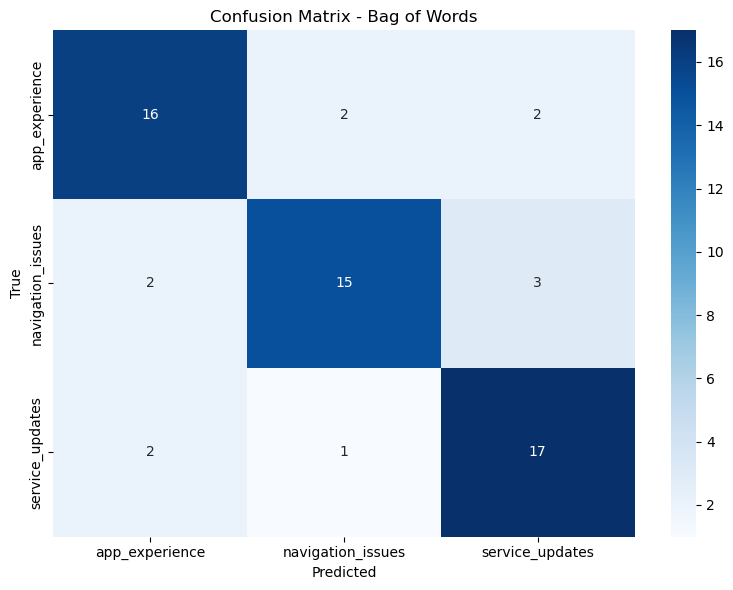


TF-IDF Model Performance:
Accuracy: 0.8000

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.84      0.80      0.82        20
navigation_issues       0.79      0.75      0.77        20
  service_updates       0.77      0.85      0.81        20

         accuracy                           0.80        60
        macro avg       0.80      0.80      0.80        60
     weighted avg       0.80      0.80      0.80        60



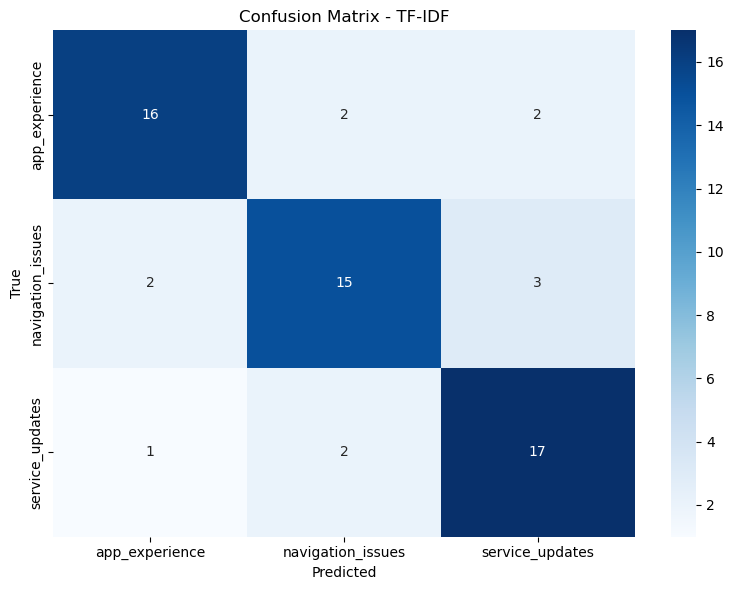


Word2Vec Model Performance:
Accuracy: 0.5167

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.64      0.45      0.53        20
navigation_issues       0.52      0.65      0.58        20
  service_updates       0.43      0.45      0.44        20

         accuracy                           0.52        60
        macro avg       0.53      0.52      0.52        60
     weighted avg       0.53      0.52      0.52        60



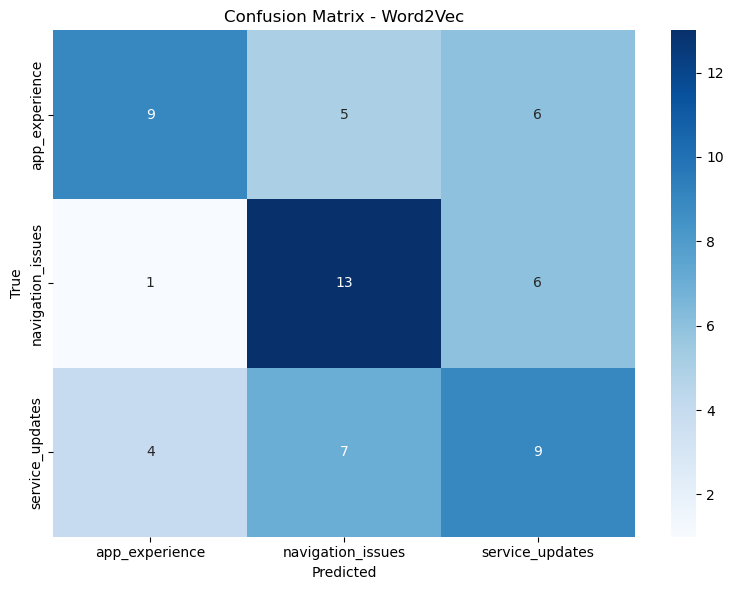

In [55]:
# Function to evaluate and display model performance
def evaluate_model(y_true, y_pred, model_name):
   """Evaluate a model and print performance metrics."""
   accuracy = accuracy_score(y_true, y_pred)
   print(f"\n{model_name} Model Performance:")
   print(f"Accuracy: {accuracy:.4f}")
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))
  
   # Create a confusion matrix
   cm = confusion_matrix(y_true, y_pred)
  
   # Plot confusion matrix as a heatmap
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=sorted(set(y_true)),
              yticklabels=sorted(set(y_true)))
   plt.title(f'Confusion Matrix - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   plt.tight_layout()
   plt.show()
  
   return accuracy


# Evaluate all models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF")
w2v_accuracy = evaluate_model(y_test, y_pred_w2v, "Word2Vec")

In [56]:
# Compare models
models = ["Bag of Words", "TF-IDF", "Word2Vec"]
accuracies = [bow_accuracy, tfidf_accuracy, w2v_accuracy]

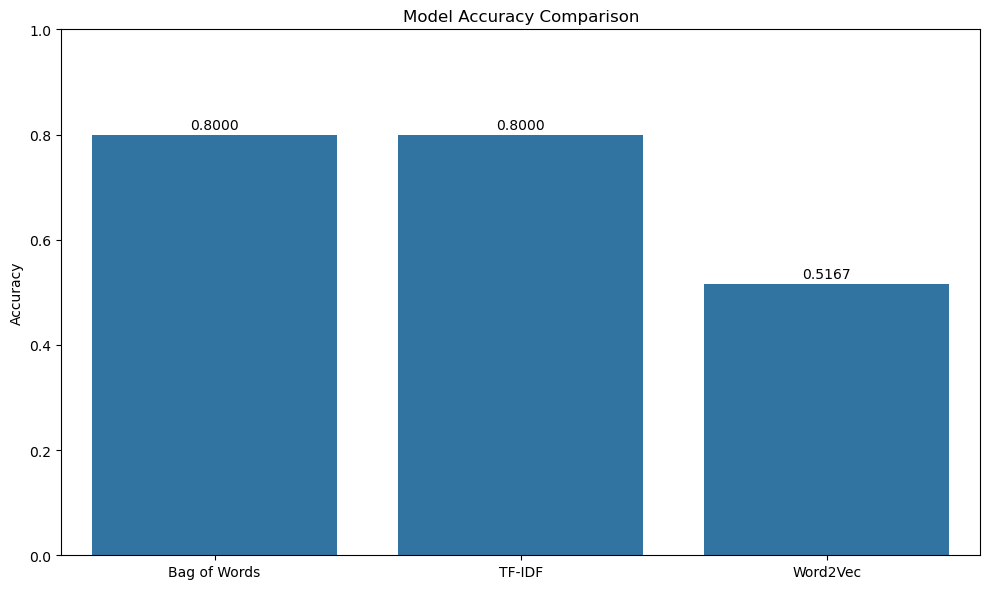

In [57]:
# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

Performing grid search to optimize model hyperparameters...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'classifier__alpha': 1.0, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Best cross-validation accuracy: 0.8765

Optimized TF-IDF Model Performance:
Accuracy: 0.8667

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.94      0.85      0.89        20
navigation_issues       1.00      0.75      0.86        20
  service_updates       0.74      1.00      0.85        20

         accuracy                           0.87        60
        macro avg       0.90      0.87      0.87        60
     weighted avg       0.90      0.87      0.87        60



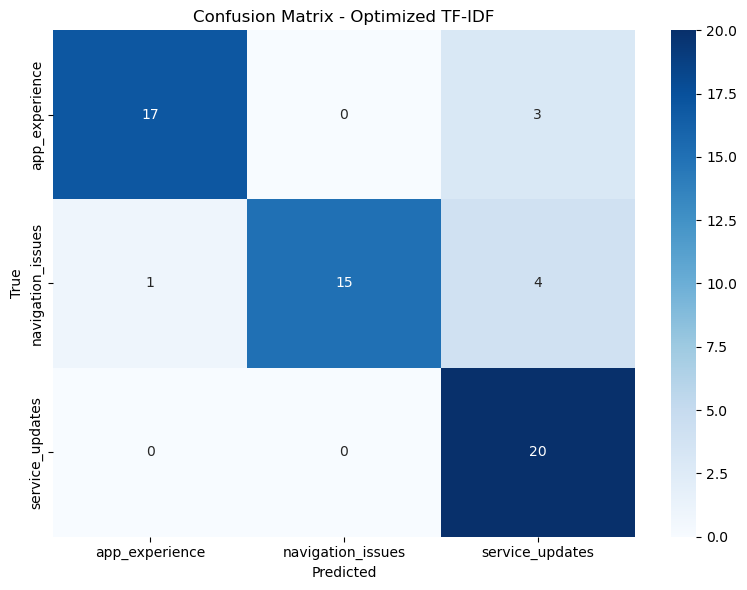

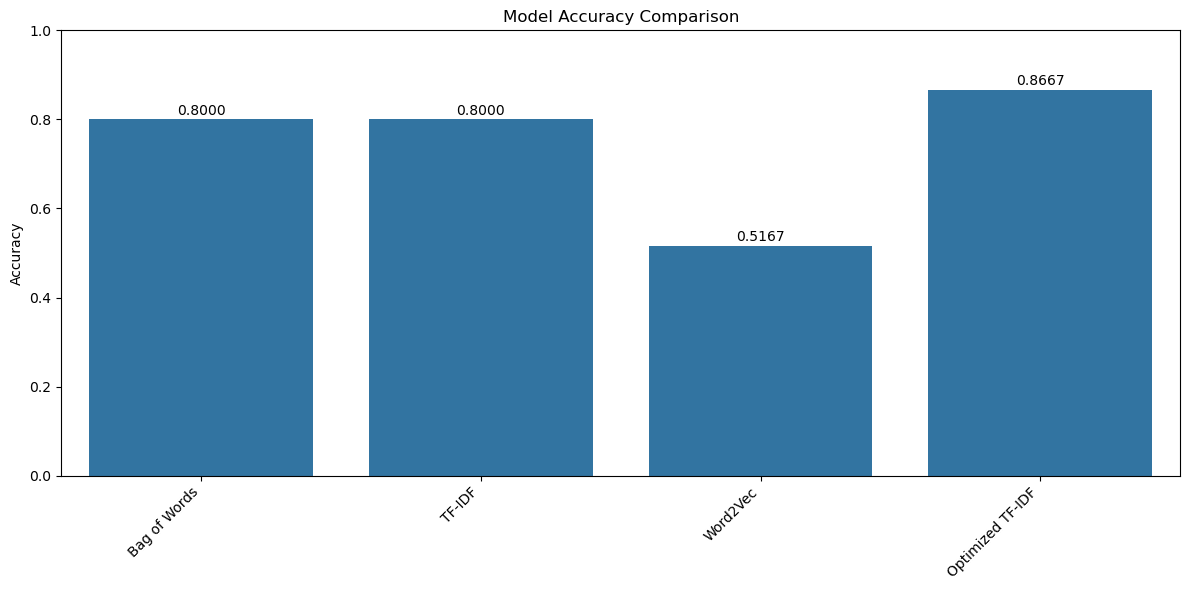

In [58]:
from sklearn.model_selection import GridSearchCV


# Create a pipeline for the TF-IDF approach
tfidf_pipeline = Pipeline([
   ('vectorizer', TfidfVectorizer(preprocessor=advanced_preprocess, lowercase=False)),
   ('classifier', MultinomialNB())
])


# Define parameter grid to search
param_grid = {
   'vectorizer__min_df': [1, 2, 3],
   'vectorizer__max_df': [0.9, 0.95, 1.0],
   'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
   'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(
   tfidf_pipeline,
   param_grid,
   cv=5,             # 5-fold cross-validation
   scoring='accuracy',
   verbose=1
)


# Fit the grid search to the data
print("Performing grid search to optimize model hyperparameters...")
grid_search.fit(X_train, y_train)


# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


# Evaluate the optimized model on test data
optimized_pipeline = grid_search.best_estimator_
y_pred_optimized = optimized_pipeline.predict(X_test)
optimized_accuracy = evaluate_model(y_test, y_pred_optimized, "Optimized TF-IDF")


# Add to our model comparison
models.append("Optimized TF-IDF")
accuracies.append(optimized_accuracy)


# Updated plot for model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()